In [57]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy
import ipynb.fs
import pandas as pd

from ipynb.fs.defs.BCI_COMP_IV_functions import (extractInfo, featureExtraction, createFilterBank,
                                                 testFrequencyBand,startRunningClassifier,tuneModelHyperParams,
                                                 testWindowStartTime, testClassifier)


In [2]:
dataA = scipy.io.loadmat("BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1a_1000Hz.mat")

dataA["cnt"] = 0.1 * dataA["cnt"].astype(float)

eeg = dataA["cnt"].T
nChannels, nSamples = eeg.shape

motionIntentComp, idleStateComp = [1,-1], [1,-4]

calibDataStore, testData_motionIntent, _ = featureExtraction(dataA,0.7, motionIntentComp, idleStateComp,)

calibData_idle_motionIntent, testData_idle_motionIntent, W_idle_motionIntent = featureExtraction(dataA,0.7,motionIntentComp,idleStateComp,ExtractionType="idle_motionIntent")




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Base Classifiers for detecting Idle State (no resampling)

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import VotingClassifier

ldaModel = LDA()
SVMmodel = SVC(probability=True,class_weight="balanced")
logRegModel = LogisticRegression(class_weight="balanced")
ensembleClassifier = VotingClassifier(estimators=[('LinearDiscriminantAnalysis', LDA()),
                                                          ('SVC', SVC(probability=True)),
                                                          ('LogisticRegression',LogisticRegression())],
                                                           voting='soft',
                                                           weights=[1,2,1])


In [4]:
nCols = len(calibData_idle_motionIntent.columns)


print("LDA: ",np.mean(cross_val_score(ldaModel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print("SVM: ",np.mean(cross_val_score(SVMmodel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print("SVM-LDA-LR: ",np.mean(cross_val_score(ensembleClassifier,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))

print()


LDA:  0.6428571428571429
Logistic Regression:  0.6535714285714286
SVM:  0.6357142857142858
SVM-LDA-LR:  0.6571428571428571



### Tuning Classifiers for detecting Idle State (no resampling)


In [5]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [6]:
bestMods = tuneModelHyperParams(calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],testData_idle_motionIntent.iloc[:,:nCols-1], testData_idle_motionIntent.iloc[:,nCols-1],votingWeights=[1,2,1])
bestMods

accuracy
---------

SVC
CV SCORE: 0.6642857142857143

-------------
LogisticRegression
CV SCORE: 0.6642857142857143

-------------
LinearDiscriminantAnalysis
cv score: 0.6571428571428573

-------------
SVC-LR-LDA
CV SCORE: 0.6571428571428571

-------------


defaultdict(dict,
            {'accuracy': {'SVC': (SVC(C=1, class_weight='balanced', gamma=1, kernel='linear', probability=True),
               0.5916666666666667),
              'LogReg': (LogisticRegression(C=0.06866488450043001, class_weight='balanced',
                                  solver='newton-cg'),
               0.5833333333333334),
              'LDA': (LinearDiscriminantAnalysis(shrinkage=0.4, solver='lsqr'),
               0.575),
              'SVC_LR_LDA': (VotingClassifier(estimators=[('LinearDiscriminantAnalysis',
                                             LinearDiscriminantAnalysis(shrinkage=0.4,
                                                                        solver='lsqr')),
                                            ('SVC',
                                             SVC(C=1, class_weight='balanced', gamma=1,
                                                 kernel='linear', probability=True)),
                                            ('LogisticRe

In [7]:
bestModel, bestPerformance = None, 0

for metric in bestMods:
    for model in bestMods[metric]:
        mod, perf = bestMods[metric][model]

        if perf > bestPerformance:
            bestModel, bestPerformance = mod, perf


In [8]:

print(bestModel, bestPerformance)


SVC(C=1, class_weight='balanced', gamma=1, kernel='linear', probability=True) 0.5916666666666667


In [9]:
idlesStateClassifier = bestModel

In [10]:
idlestateEnsemble = bestMods["accuracy"]["SVC_LR_LDA"][0]


In [11]:
idlestateEnsemble

VotingClassifier(estimators=[('LinearDiscriminantAnalysis',
                              LinearDiscriminantAnalysis(shrinkage=0.4,
                                                         solver='lsqr')),
                             ('SVC',
                              SVC(C=1, class_weight='balanced', gamma=1,
                                  kernel='linear', probability=True)),
                             ('LogisticRegression',
                              LogisticRegression(C=0.06866488450043001,
                                                 class_weight='balanced',
                                                 solver='newton-cg'))],
                 voting='soft', weights=[1, 2, 1])

### Base Classifier for classifying motion intent signals

In [12]:

ldaModel = LDA()
SVMmodel = SVC(probability=True,class_weight="balanced")
logRegModel = LogisticRegression(class_weight="balanced")
ensembleClassifier = VotingClassifier(estimators=[('LinearDiscriminantAnalysis', LDA()),
                                                          ('SVC', SVC(probability=True)),
                                                          ('LogisticRegression',LogisticRegression())],
                                                           voting='soft',
                                                           weights=[1,2,1])


In [13]:
for name, calibData in calibDataStore.items():

    nCols = len(calibData.columns)
    print(name,end="\n")
    print("-----------")

    print("LDA: ",np.mean(cross_val_score(ldaModel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("SVM: ",np.mean(cross_val_score(SVMmodel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("SVM-LDA-LR: ",np.mean(cross_val_score(ensembleClassifier,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))

    print()


RO
-----------
LDA:  0.8603448275862069
Logistic Regression:  0.8672413793103448
SVM:  0.8672413793103448
SVM-LDA-LR:  0.8672413793103448

SMOTE
-----------
LDA:  0.8603448275862069
Logistic Regression:  0.8672413793103448
SVM:  0.8672413793103448
SVM-LDA-LR:  0.8600985221674877

RU
-----------
LDA:  0.8626984126984126
Logistic Regression:  0.8769841269841269
SVM:  0.8555555555555555
SVM-LDA-LR:  0.8769841269841269

CC
-----------
LDA:  0.8637566137566137
Logistic Regression:  0.8637566137566137
SVM:  0.8777777777777777
SVM-LDA-LR:  0.8563492063492063

None
-----------
LDA:  0.8571428571428571
Logistic Regression:  0.8642857142857142
SVM:  0.8642857142857142
SVM-LDA-LR:  0.8571428571428571



### Hyperparameter Tuning

In [14]:
for name, calibData in calibDataStore.items():

    bestMods = tuneModelHyperParams(calibData.iloc[:,:nCols-1],
                                    calibData.iloc[:,nCols-1],
                                    testData_motionIntent.iloc[:,:nCols-1],
                                    testData_motionIntent.iloc[:,nCols-1],
                                    votingWeights=[1,2,1])

    bestModel, bestPerformance = None, 0

    for metric in bestMods:
        for model in bestMods[metric]:
            mod, perf = bestMods[metric][model]

            if perf > bestPerformance:
                bestMetric, bestModel, bestPerformance = metric, mod, perf

    print(name)
    print("-------")
    print(f"Model = {bestModel}, Performance = {bestPerformance}, Metric = {bestMetric} ")
    print()
    print(f"All metrics = {bestMods}")
    print()


accuracy
---------

SVC
CV SCORE: 0.8810344827586206

-------------
LogisticRegression
CV SCORE: 0.8810344827586206

-------------
LinearDiscriminantAnalysis
cv score: 0.8741379310344828

-------------
SVC-LR-LDA
CV SCORE: 0.8810344827586206

-------------
RO
-------
Model = SVC(C=100, class_weight='balanced', gamma=0.01, probability=True), Performance = 0.8833333333333333, Metric = accuracy 

All metrics = defaultdict(<class 'dict'>, {'accuracy': {'SVC': (SVC(C=100, class_weight='balanced', gamma=0.01, probability=True), 0.8833333333333333), 'LogReg': (LogisticRegression(C=0.06866488450043001, class_weight='balanced',
                   solver='newton-cg'), 0.8833333333333333), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.1, solver='lsqr'), 0.8666666666666667), 'SVC_LR_LDA': (VotingClassifier(estimators=[('LinearDiscriminantAnalysis',
                              LinearDiscriminantAnalysis(shrinkage=0.1,
                                                         solver='lsqr')),
    

### Window Start Time Test

accuracy
---------

SVC
CV SCORE: 0.8785714285714284

-------------
LogisticRegression
CV SCORE: 0.8785714285714284

-------------
LinearDiscriminantAnalysis
cv score: 0.8571428571428571

-------------
SVC-LR-LDA
CV SCORE: 0.8785714285714284

-------------
accuracy
---------

SVC
CV SCORE: 0.7714285714285715

-------------
LogisticRegression
CV SCORE: 0.7785714285714286

-------------
LinearDiscriminantAnalysis
cv score: 0.7714285714285715

-------------
SVC-LR-LDA
CV SCORE: 0.7642857142857143

-------------
accuracy
---------

SVC
CV SCORE: 0.9428571428571428

-------------
LogisticRegression
CV SCORE: 0.9428571428571428

-------------
LinearDiscriminantAnalysis
cv score: 0.9214285714285715

-------------
SVC-LR-LDA
CV SCORE: 0.9357142857142857

-------------
accuracy
---------

SVC
CV SCORE: 0.7

-------------
LogisticRegression
CV SCORE: 0.7071428571428571

-------------
LinearDiscriminantAnalysis
cv score: 0.6928571428571428

-------------
SVC-LR-LDA
CV SCORE: 0.6857142857142857

-

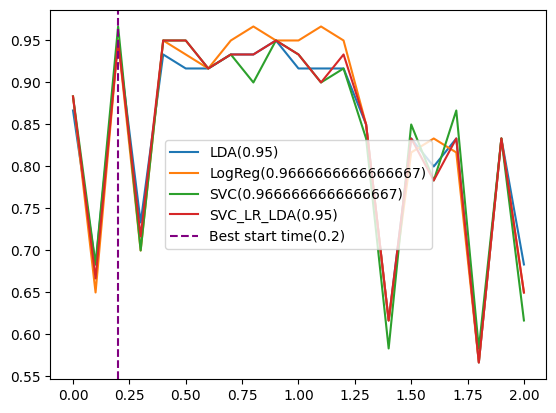

In [15]:
bestEstimator_start_time, W_start_time = testWindowStartTime(dataA,
                                                             0.7,
                                                             4,
                                                             motionIntentComp,
                                                             idleStateComp,
                                                             votingWeights=[1,2,1])


### Investigating the effect of varying the frquency band (for each resampling technique)

In [16]:
channelNames,sRate,classLabels,eventOnsets,eventCodes,labels = extractInfo(dataA,nSamples)

filterBank = createFilterBank(sRate)

freqBandEstimators = {}


In [17]:
#Populate a dictionary with frequency band estimators for each resampling technique


for resamplerType in calibDataStore.keys():
    print(resamplerType)
    print("------------")
    bestBand, bestEstimator_freq_band, (best_b, best_a), W_freq_band, allBandPerformanceMetrics = testFrequencyBand(dataA,
                                                                                         filterBank,
                                                                                         0.7,
                                                                                         motionIntentComp,
                                                                                         idleStateComp,
                                                                                         trialWinStart=0,
                                                                                         trialWinEnd = 4,
                                                                                         resampler=resamplerType,
                                                                                         votingWeights=[1,2,1])

    print()

    freqBandEstimators[resamplerType] = (bestBand, bestEstimator_freq_band, (best_b, best_a), W_freq_band, allBandPerformanceMetrics[bestBand])


RO
------------
accuracy
---------

SVC
CV SCORE: 0.8810344827586206

-------------
LogisticRegression
CV SCORE: 0.8810344827586206

-------------
LinearDiscriminantAnalysis
cv score: 0.8741379310344828

-------------
SVC-LR-LDA
CV SCORE: 0.8810344827586206

-------------
8-12 : 0.8833333333333333 (accuracy)

All Metrics: defaultdict(<class 'dict'>, {'accuracy': {'SVC': (SVC(C=100, class_weight='balanced', gamma=0.01, probability=True), 0.8833333333333333), 'LogReg': (LogisticRegression(C=0.06866488450043001, class_weight='balanced',
                   solver='newton-cg'), 0.8833333333333333), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.1, solver='lsqr'), 0.8666666666666667), 'SVC_LR_LDA': (VotingClassifier(estimators=[('LinearDiscriminantAnalysis',
                              LinearDiscriminantAnalysis(shrinkage=0.1,
                                                         solver='lsqr')),
                             ('SVC',
                              SVC(C=100, class_weight=

RO resampler optimal threshold : 0.5590375272109629
SMOTE resampler optimal threshold : 0.5923312634209292
RU resampler optimal threshold : 0.6115278587815824
CC resampler optimal threshold : 0.6427282003421442
None resampler optimal threshold : 0.5839768683246905


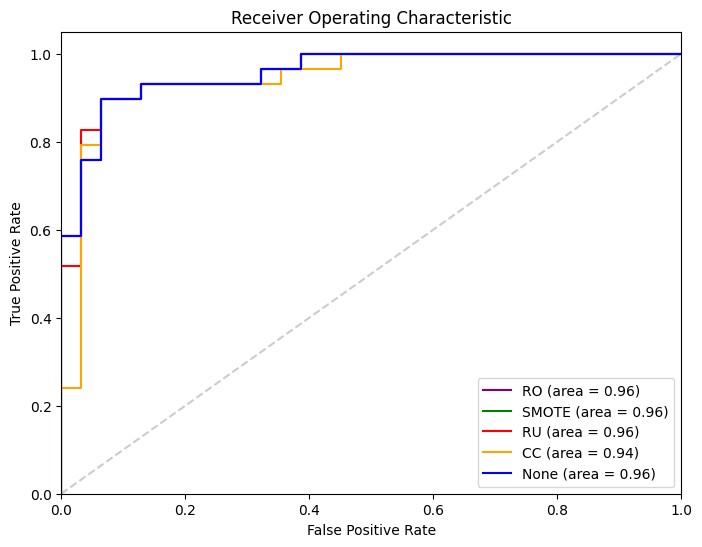

In [44]:
plt.figure(figsize=(8, 6))
colour_idx = 0
colours = ['purple', 'green', 'red','orange','blue']

for name, (best_band,estimator, filter_b_a, best_W, _) in freqBandEstimators.items():
    probs = estimator.predict_proba(testData_motionIntent.iloc[:,:nCols-1])
    probs = probs[:, 1]  # use the probability of the positive class
    true_labels = testData_motionIntent.iloc[:,nCols-1]

    # Calculate ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(true_labels, probs)
    auc_score = auc(fpr, tpr)

    # Plot ROC curve for current model
    plt.plot(fpr, tpr, color=colours[colour_idx], label= name + ' (area = %0.2f)' % auc_score)
    colour_idx += 1

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(f"{name} resampler optimal threshold : {optimal_threshold}")

plt.plot([0, 1], [0, 1], 'k--',alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [60]:
_, bestEstimator_freq_band, (best_b,best_a), W_freq_band, allBandPerformanceMetrics = freqBandEstimators["RU"] 


In [46]:
bestEstimator_freq_band

SVC(C=1, class_weight='balanced', gamma=0.1, probability=True)

In [47]:
motionIntentEnsemble = allBandPerformanceMetrics["accuracy"]["SVC_LR_LDA"][0]


In [48]:
motionIntentEnsemble


VotingClassifier(estimators=[('LinearDiscriminantAnalysis',
                              LinearDiscriminantAnalysis(shrinkage=0.9,
                                                         solver='lsqr')),
                             ('SVC',
                              SVC(C=1, class_weight='balanced', gamma=0.1,
                                  probability=True)),
                             ('LogisticRegression',
                              LogisticRegression(C=0.0030888435964774815,
                                                 solver='newton-cg'))],
                 voting='soft', weights=[1, 2, 1])

### Person's Correlation Coefficient (PCC) + CSP

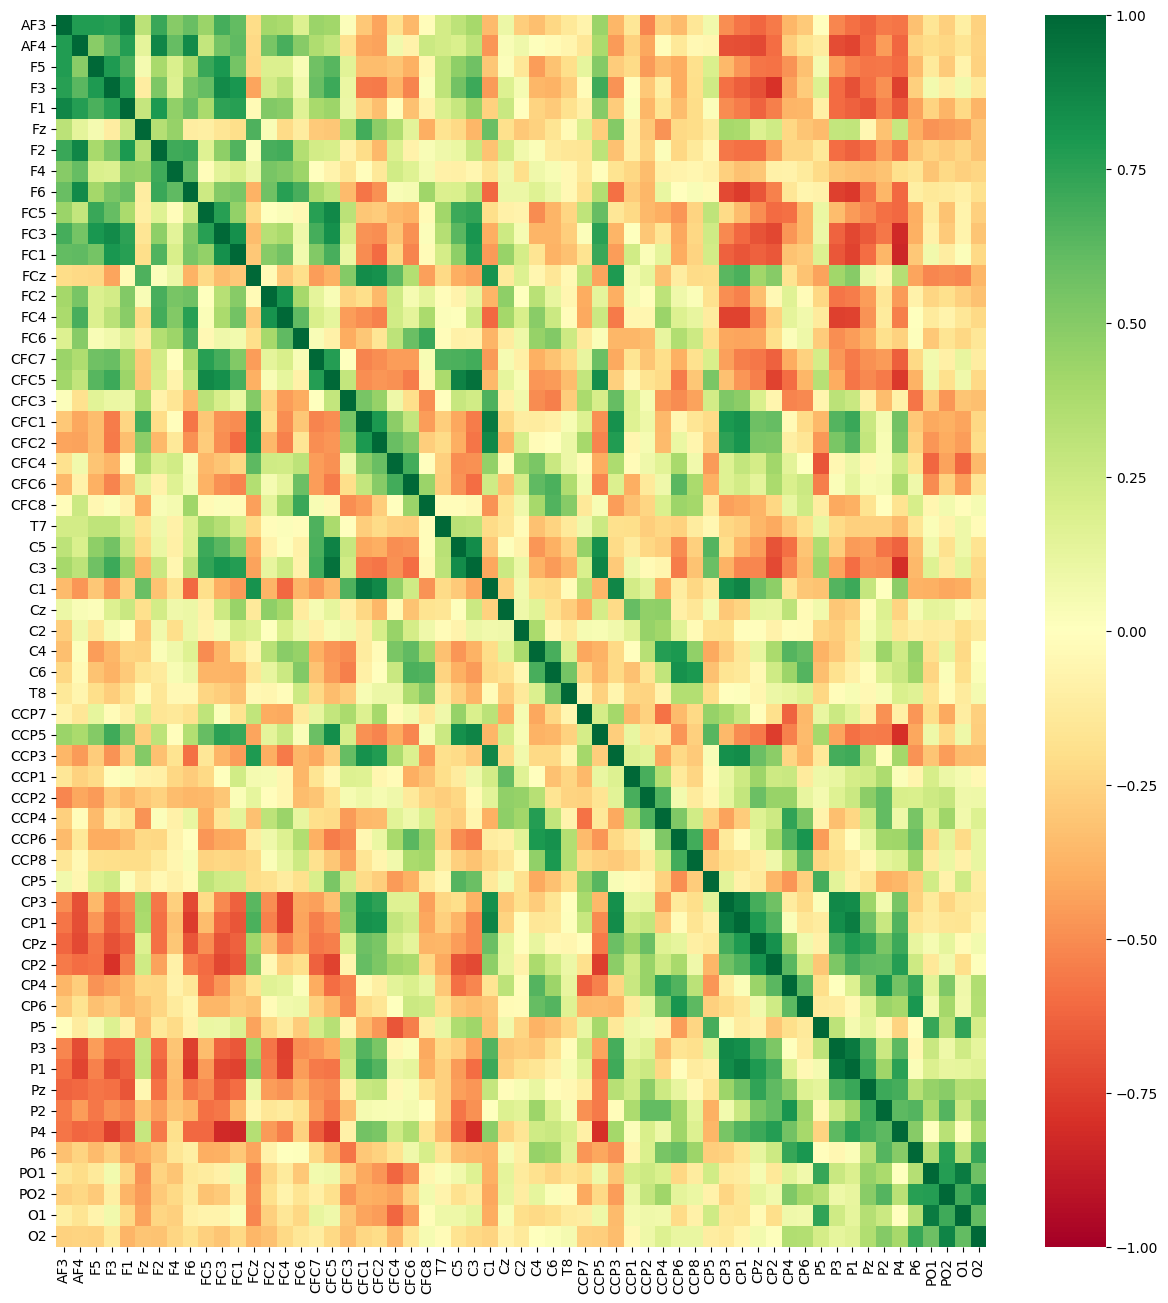

In [55]:
#Plot distributions of channels against eachother
# to find out if there is any sort of positive correlation
# between channels

import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
trialWin = np.arange(int(0*sRate),int(4*sRate))

# #get mixed trial data from original
trials_mixed = np.zeros(
            (nChannels, len(eventOnsets[0]), len(trialWin)))


for i, onset in enumerate(eventOnsets[0]):
    trials_mixed[:,i,:] = eeg[:,onset+trialWin]

# By augmenting the algorithm outlined in [ref: Electroencephalogram channel selection based on pearson correlation coefficient for motor imagery-brain-computer interface]
# we can able to extract the most correlated channels in the given data prior to selecting features with the CSP algorithm.


scaler = StandardScaler()

# For each trial
#We must standardize the values in each trial window for each channel (We use z-score normalization for this)
_, nTrials, _ = trials_mixed.shape

trialChannelCorrelations = []

plotFirst = False #flag to check that heatmap of first trial is plotted

for trial in range(nTrials):

    zTrial = scaler.fit_transform(trials_mixed[:,trial,:])
    corrMat = np.corrcoef(zTrial)

    if not plotFirst:
        plt.figure(figsize=(15, 16))
        sns.heatmap(pd.DataFrame(corrMat,columns=channelNames,index=channelNames),cmap="RdYlGn",vmin=-1,vmax=1)
        plotFirst = True

#     # We must then calculate the correlation matrices for each trial and return the mean for each row, giving us a vector of mean values
#     # which represents the average corellation values for a specific channel in relation to other channels.
    channelCorrValues = {ch:corrMean for (ch,corrMean) in zip(channelNames,np.mean(corrMat,axis=1))}

#     #Following the above referenced paper, we select the first 14 channels

    channelCorrValues = dict(sorted(channelCorrValues.items(), key=lambda x:x[1], reverse=True)[:14])
    trialChannelCorrelations.append(channelCorrValues)


<AxesSubplot: >

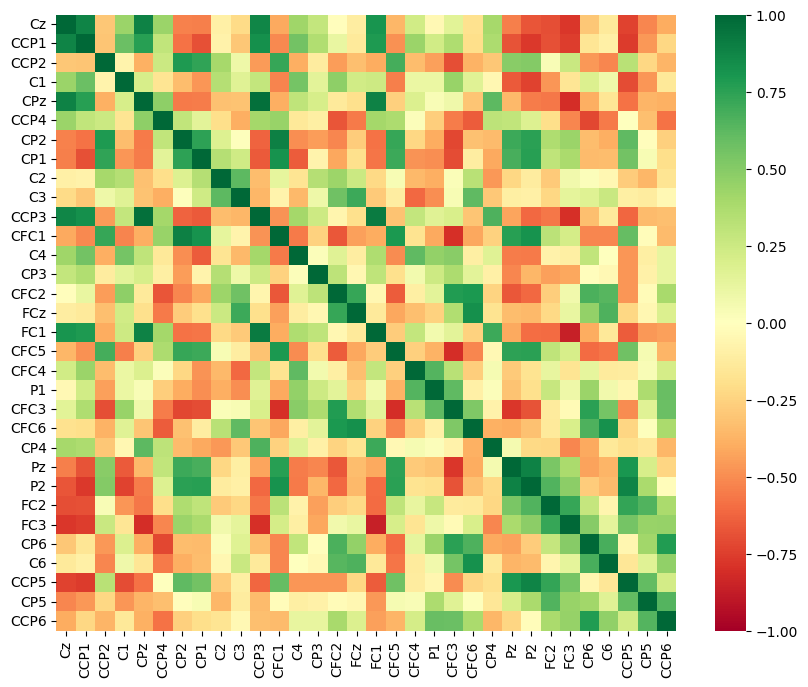

In [56]:
from collections import defaultdict

channelOccurences = defaultdict(int)

for dic in trialChannelCorrelations:
    for ch, _ in dic.items():
        channelOccurences[ch] += 1


# This represent the most correlated channels ordered (descending) by the number of time they appear
# in the most correlated channel list for each trial
channelOccurences = dict(sorted(channelOccurences.items(), key=lambda x:x[1], reverse=True))

selectedChannels = list(channelOccurences.keys())[:32]
#It can be seen that all selected channels are in and around the sensorimotor cortex

selectedSet = set(selectedChannels)
selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

#Plot heatmap of first trial
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(np.corrcoef(scaler.fit_transform(trials_mixed[selectedIdxs,0,:])),
            columns=selectedChannels,
            index=selectedChannels),
            cmap="RdYlGn",
            vmin=-1,
            vmax=1)


In [67]:
channelNums = dict()

for i in range(2,nChannels+1):
    selectedChannels = list(channelOccurences.keys())[:i]
    #It can be seen that all selected channels are in and around the sensorimotor cortex

    selectedSet = set(selectedChannels)
    selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

    bestEstimator_selected_channels = None
    
    bestAccVal, bestEstimator_selected_channels, _, _, _  =  testClassifier(dataA,
                                                                           0,
                                                                           4,
                                                                           0.7,
                                                                           [0,-1],
                                                                           [0,-1],
                                                                           b=best_b,
                                                                           a=best_a,
                                                                           selectedChannels=selectedIdxs,
                                                                           votingWeights=[1,2,1])


    channelNums[i] = bestAccVal #Test set performances


accuracy
---------

SVC
CV SCORE: 0.642857142857143

-------------
LogisticRegression
CV SCORE: 0.6

-------------
LinearDiscriminantAnalysis
cv score: 0.5857142857142856

-------------
SVC-LR-LDA
CV SCORE: 0.55

-------------
accuracy
---------

SVC
CV SCORE: 0.7928571428571429

-------------
LogisticRegression
CV SCORE: 0.7928571428571429

-------------
LinearDiscriminantAnalysis
cv score: 0.7857142857142857

-------------
SVC-LR-LDA
CV SCORE: 0.7785714285714286

-------------
accuracy
---------

SVC
CV SCORE: 0.8071428571428572

-------------
LogisticRegression
CV SCORE: 0.8142857142857143

-------------
LinearDiscriminantAnalysis
cv score: 0.8142857142857143

-------------
SVC-LR-LDA
CV SCORE: 0.8071428571428572

-------------
accuracy
---------

SVC
CV SCORE: 0.8071428571428572

-------------
LogisticRegression
CV SCORE: 0.8

-------------
LinearDiscriminantAnalysis
cv score: 0.7928571428571429

-------------
SVC-LR-LDA
CV SCORE: 0.8

-------------
accuracy
---------

SVC
CV SCORE

In [68]:
bestEstimator_selected_channels

LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr')

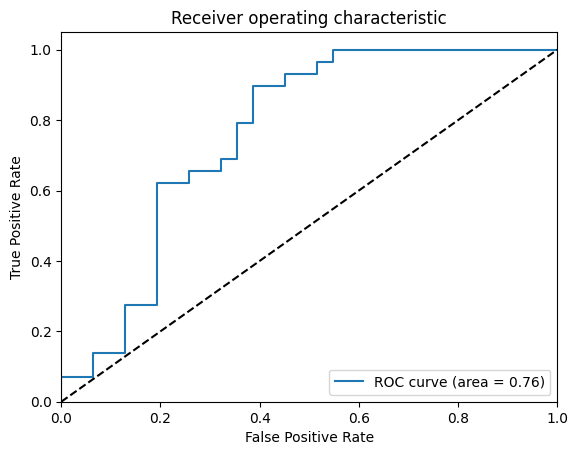

In [69]:
probs = bestEstimator_selected_channels.predict_proba(testData_motionIntent.iloc[:,:nCols-1])
probs = probs[:, 1]  # use the probability of the positive class
true_labels = testData_motionIntent.iloc[:,nCols-1]

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_labels, probs)
auc_score = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


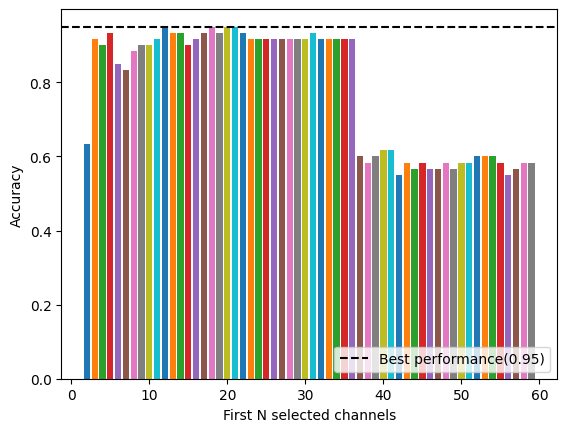

In [72]:
bestY = 0
for x, y in channelNums.items():
    bestY= max(bestY,y)
    plt.bar(x,y)

plt.xlabel("First N selected channels")
plt.ylabel("Accuracy")
plt.axhline(y=bestY, color='black', ls='--', lw=1.5, label=f"Best performance({bestY})")
plt.legend(loc='lower right')


### Calibration of best classifier to predict probability outputs for all time samples

In [49]:
evalDataA = scipy.io.loadmat("BCICIV_1eval_1000Hz_mat/BCICIV_eval_ds1a_1000Hz.mat")


In [50]:
bestEstimator_freq_band

SVC(C=1, class_weight='balanced', gamma=0.1, probability=True)

In [51]:
idlesStateClassifier


SVC(C=1, class_weight='balanced', gamma=1, kernel='linear', probability=True)

In [52]:
from sklearn.calibration import CalibratedClassifierCV

bestEstimator_freq_band = CalibratedClassifierCV(bestEstimator_freq_band,cv="prefit")
bestEstimator_freq_band.fit(testData_motionIntent.iloc[:,:nCols-1], testData_motionIntent.iloc[:,nCols-1])

motionIntentEnsemble = CalibratedClassifierCV(motionIntentEnsemble,cv="prefit")
motionIntentEnsemble.fit(testData_motionIntent.iloc[:,:nCols-1], testData_motionIntent.iloc[:,nCols-1])


CalibratedClassifierCV(cv='prefit',
                       estimator=VotingClassifier(estimators=[('LinearDiscriminantAnalysis',
                                                               LinearDiscriminantAnalysis(shrinkage=0.9,
                                                                                          solver='lsqr')),
                                                              ('SVC',
                                                               SVC(C=1,
                                                                   class_weight='balanced',
                                                                   gamma=0.1,
                                                                   probability=True)),
                                                              ('LogisticRegression',
                                                               LogisticRegression(C=0.0030888435964774815,
                                                                                  solver='newton-cg'))],
                                                  voting='soft',
                                                  weights=[1, 2, 1]))

#### Calibrate SVC

In [53]:
probabilities, probabilities_ensemble = startRunningClassifier(evalDataA,
                                       bestEstimator_freq_band,
                                       idlesStateClassifier,
                                       motionIntentComp,
                                       idleStateComp,
                                       W_freq_band,
                                       W_idle_motionIntent,
                                       trialWinStart=0,
                                       trialWinEnd=4,
                                       b=best_b,
                                       a=best_a,
                                       idleStateEnsembleClassifer= idlestateEnsemble,
                                       calibratedEnsembleClassifier= motionIntentEnsemble)


In [54]:
import csv

with open("output_subject_a_1000Hz.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(probabilities)

with open("output_subject_a_1000Hz_ensemble.csv", "w") as e:
    wr = csv.writer(e)
    wr.writerows(probabilities_ensemble)
